In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import math
import random
from matplotlib.patches import Rectangle
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from torchvision.transforms.functional import to_pil_image
import json
# from transformers import pipeline
# pipe = pipeline("object-detection", model="facebook/detr-resnet-101")

MODEL_NAME="google/vit-large-patch16-224-in21k"
BATCH_SIZE=64

device='cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-1-7b4d843c4620>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'cpu'

In [2]:
detr_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-101", use_fast=True)
detr_model = torch.compile(AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-101"))

vit_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/243M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [3]:
root_dir=Path("/kaggle/input/bdma-compatition/BDMA7_project_files/")

train_metadata_path = root_dir/"train_metadata.csv"  # Path to the metadata file
train_images_dir = root_dir/"train_images"       # Path to training images directory

val_metadata_path = root_dir/"val_metadata.csv"      # Path to validation metadata file
val_images_dir = root_dir/"val_images"           # Path to validation images directory

test_images_dir = root_dir/"test_images/mistery_cat"

df_train = pd.read_csv(train_metadata_path)
df_train["path"] = train_images_dir/df_train["path"]

df_val = pd.read_csv(val_metadata_path)
df_val["path"] = val_images_dir/df_val["path"]

df_test = pd.DataFrame(
    data = {
    "path": [path for path in test_images_dir.glob("*.jpg")]
    }
)

df_train

,path,class,class_idx
0,/kaggle/input/bdma-compatition/BDMA7_project_f...,Brandt_Cormorant,4
1,/kaggle/input/bdma-compatition/BDMA7_project_f...,Brandt_Cormorant,4
2,/kaggle/input/bdma-compatition/BDMA7_project_f...,Brandt_Cormorant,4
3,/kaggle/input/bdma-compatition/BDMA7_project_f...,Brandt_Cormorant,4
4,/kaggle/input/bdma-compatition/BDMA7_project_f...,Brandt_Cormorant,4
...,...,...,...
1077,/kaggle/input/bdma-compatition/BDMA7_project_f...,Gray_Catbird,3
1078,/kaggle/input/bdma-compatition/BDMA7_project_f...,Gray_Catbird,3
1079,/kaggle/input/bdma-compatition/BDMA7_project_f...,Gray_Catbird,3
1080,/kaggle/input/bdma-compatition/BDMA7_project_f...,Gray_Catbird,3


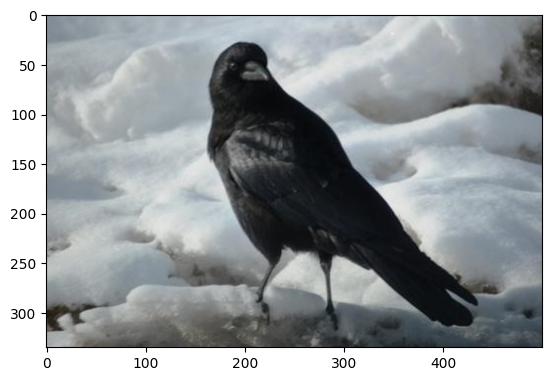

In [4]:
image=torchvision.io.read_image(df_test["path"][20])
plt.imshow(image.permute(1,2,0))

In [5]:
processed_image=detr_processor(image, return_tensors="pt")
processed_image

{'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[ 0.1768,  0.1768,  0.1768,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.0972, -0.1143, -0.1143],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.0629, -0.0801, -0.0801],
          ...,
          [ 0.7762,  0.7762,  0.7591,  ..., -1.2103, -1.2274, -1.2274],
          [ 0.7933,  0.7933,  0.7762,  ..., -1.2274, -1.2445, -1.2445],
          [ 0.7933,  0.7933,  0.7762,  ..., -1.2274, -1.2445, -1.2445]],

         [[ 0.4853,  0.4853,  0.4853,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.4853,  0.4853,  0.4853,  ...,  0.1176,  0.1001,  0.1001],
          [ 0.4853,  0.4853,  0.4853,  ...,  0.1527,  0.1352,  0.1352],
          ...,
          [ 0.9930,  0.9930,  0.9755,  ..., -0.9153, -0.9328, 

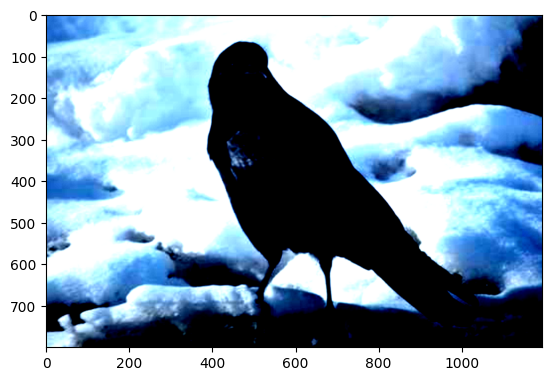

In [6]:
plt.imshow(processed_image["pixel_values"].squeeze(0).permute(1,2,0))

In [7]:
detection=detr_model(processed_image["pixel_values"])

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [8]:
# [processed_image["pixel_values"].shape[-2:]]
results = detr_processor.post_process_object_detection(detection, target_sizes=None, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {detr_model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected bird with confidence 0.999 at location [0.32, 0.08, 0.88, 0.97]


In [9]:
fxmin, fymin, fxmax, fymax = torch.tensor(box)
fxmin, fymin, fxmax, fymax

(tensor(0.3200), tensor(0.0800), tensor(0.8800), tensor(0.9700))

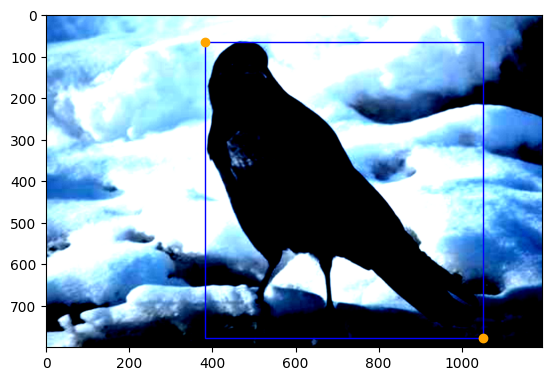

In [10]:
height, width = processed_image["pixel_values"].shape[-2:]
xmin, xmax = fxmin*width, fxmax*width
ymin, ymax = fymin*height, fymax*height
fig, ax= plt.subplots()
ax.imshow(processed_image["pixel_values"].squeeze(0).permute(1,2,0))
ax.add_patch(
    Rectangle(
        (xmin, ymin),  # (x, y) bottom-left corner
        xmax-xmin,   # Width of the bounding box
        ymax-ymin,   # Height of the bounding box
        fill=False,
        color="blue")
)
plt.scatter(xmin, ymin, color="orange")
plt.scatter(xmax, ymax, color="orange")

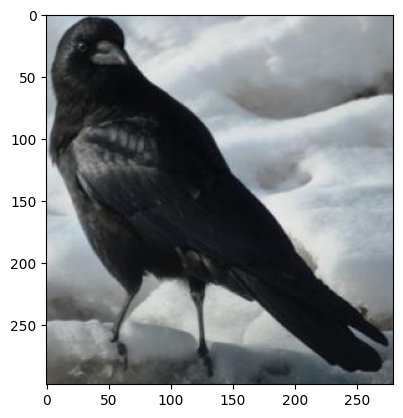

In [11]:
height, width = image.shape[1:]
xmin, xmax = int(fxmin*width), int(fxmax*width)
ymin, ymax = int(fymin*height), int(fymax*height)

cropped_image=torchvision.transforms.functional.crop(img=image, top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
fig, ax= plt.subplots()
ax.imshow(cropped_image.permute(1,2,0))

In [12]:
def crop_images(save_path, imgs_paths):
    missing={
        "count": 0,
        "paths": [],
        "total": len(imgs_paths)
    }
    
    for path in tqdm(imgs_paths):
        img=torchvision.io.read_image(path)
        processed_image=detr_processor(img, return_tensors="pt")
        detection=detr_model(processed_image["pixel_values"])
        results = detr_processor.post_process_object_detection(detection, target_sizes=None, threshold=0.9)[0]

        real_box=[]
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            # print(
            #         f"Detected {detr_model.config.id2label[label.item()]} with confidence "
            #         f"{round(score.item(), 3)} at location {box}"
            # )
            if detr_model.config.id2label[label.item()]=="bird":
                real_box=box
                break

        if len(real_box)==0:
            print("No bird detected !!!!")
            missing["count"]+=1
            missing["paths"].append(path)
            cropped_image = img
        else:
            height, width = img.shape[1:]
            fxmin, fymin, fxmax, fymax = torch.tensor(real_box)
            xmin, xmax = int(fxmin*width), int(fxmax*width)
            ymin, ymax = int(fymin*height), int(fymax*height)
            cropped_image=torchvision.transforms.functional.crop(img=img, top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
            
        cropped_pil = to_pil_image(cropped_image)
        cropped_pil.save(save_path/(path.name))

        
    return missing

In [13]:
missed_images={}

In [14]:
save_dir=Path("./train")
save_dir.mkdir(exist_ok=True)
missed_images["train"]=crop_images(save_dir ,df_train["path"])

  0%|          | 0/1082 [00:00<?, ?it/s]

W0131 12:52:47.654000 12 torch/_dynamo/convert_frame.py:844] [0/8] torch._dynamo hit config.cache_size_limit (8)
W0131 12:52:47.654000 12 torch/_dynamo/convert_frame.py:844] [0/8]    function: 'forward' (/usr/local/lib/python3.10/dist-packages/transformers/models/detr/modeling_detr.py:1379)
W0131 12:52:47.654000 12 torch/_dynamo/convert_frame.py:844] [0/8]    last reason: 0/0: tensor 'L['pixel_values']' size mismatch at index 3. expected 1194, actual 1277
W0131 12:52:47.654000 12 torch/_dynamo/convert_frame.py:844] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0131 12:52:47.654000 12 torch/_dynamo/convert_frame.py:844] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!


In [15]:
save_dir=Path("./val")
save_dir.mkdir(exist_ok=True)
missed_images["val"]=crop_images(save_dir ,df_val["path"])

  0%|          | 0/103 [00:00<?, ?it/s]

No bird detected !!!!
No bird detected !!!!


In [16]:
save_dir=Path("./test")
save_dir.mkdir(exist_ok=True)
missed_images["test"]=crop_images(save_dir ,df_test["path"])

  0%|          | 0/400 [00:00<?, ?it/s]

No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!
No bird detected !!!!


In [17]:
with open("missed_images.json", "w") as outfile:
    json.dump(missed_images, outfile)

TypeError: Object of type PosixPath is not JSON serializable

In [ ]:
!zip -r birds_dataset_cropped.zip train test val